In [1]:
import os
import numpy as np
import music21 as m21
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats
import time

np.random.seed(777)
us = m21.environment.UserSettings()
us['musescoreDirectPNGPath']='/home/sirivasv/.local/bin/MuseScore-3.5.2.312125617-x86_64.AppImage'
# us['musescoreDirectPNGPath']="/home/sirivasv/Downloads/MuseScore-3.4.2-x86_64.AppImage"

# Define dataset paths
MXML_PATH="/media/sirivasv/DATAL/MCC/DATASUBSET/MTC-ANN-2.0.1/mid"
# MXML_PATH="/media/sirivasv/JASON/Saul/MCC/DATASETS/DATASUBSET/MTC-ANN-2.0.1/mid"

METADATA_PATH="/media/sirivasv/DATAL/MCC/DATASUBSET/MTC-ANN-2.0.1/metadata" 
# METADATA_PATH="/media/sirivasv/JASON/Saul/MCC/DATASETS/DATASUBSET/MTC-ANN-2.0.1/metadata"

In [2]:
DIV_CONST = 64
raw_difference_results_LOADED = {}
with open('./HEURISTIC_TEMPOMETRIC_1_{0}_NOISE_RAW_v106_1606934412.760601.json'.format(DIV_CONST)) as json_file:
    raw_difference_results_LOADED = json.load(json_file)

## Graphs

In [3]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [4]:
def plot_conf_noises(metric_values_, differences_percentages_, diff_x_noises_):
    fig, axs = plt.subplots(7, 1, figsize=(12, 6 * 7))
    # print(differences_percentages_)
    
    # Graphs per noise type
    for noise_i in range(len_noise_types):
        axs_to_plot = axs[noise_i]
        rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), differences_percentages_[noise_i])
        autolabel(rects, axs_to_plot)
        axs_to_plot.set_title(label="Noise #" + str(noise_i + 1))
    
    # Graph mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    axs_to_plot = axs[5]
    rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), grouped_percentage_values, color="orange")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Differences across all Noises")
    
    # Graph with mean for each noise accross percentages
    axs_to_plot = axs[6]
    rects = axs_to_plot.bar(list(range(1,6)), list(map(np.mean, differences_percentages_)), color="red")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Noise Difference")
        

In [5]:
def get_mean_diff_vectors(differences_percentages_):
    # Get Mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    return grouped_percentage_values, list(map(np.mean, differences_percentages_))

In [6]:
def plot_conf_best_noises(raw_calculations):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6 * 2))
    differences_percentages_ = raw_calculations[1]
    # Graph mean per percentage across noises
    grouped_percentage_values = []
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values.append([])
        
    for noise_i in range(len_noise_types):
        perc_i = 0
        for percentage in map(int, np.linspace(10, 100, 10)):
            grouped_percentage_values[perc_i].append(differences_percentages_[noise_i][perc_i])
            perc_i += 1
    perc_i = 0
    for percentage in map(int, np.linspace(10, 100, 10)):
        grouped_percentage_values[perc_i] = np.mean(grouped_percentage_values[perc_i])
        perc_i += 1
        
    axs_to_plot = axs[0]
    rects = axs_to_plot.bar(list(map(str, np.linspace(10, 100, 10))), grouped_percentage_values, color="orange")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Differences across all Noises")
    
    # Graph with mean for each noisea accross percentages
    axs_to_plot = axs[1]
    rects = axs_to_plot.bar(list(range(1,6)), list(map(np.mean, differences_percentages_)), color="red")
    autolabel(rects, axs_to_plot)
    axs_to_plot.set_title(label="Mean Noise Difference")

## Experiment results

In [7]:
def get_weights_from_encoded_conf(encoded_conf):
    return tuple(map(lambda x: x, map(float, encoded_conf.split(","))))

In [8]:
%%time
# Define noise type array
noise_types = [1, 2, 3, 4, 5]
len_noise_types = len(noise_types)

# Define the percentages of noise
noise_percentages = list(map(int, np.linspace(10, 100, 10)))
mad_and_std_per_noise_and_percentage = {}
for conf_i, encoded_conf in enumerate(raw_difference_results_LOADED):
    
    mad_and_std_per_noise_and_percentage[encoded_conf] = {}
    (W1, W2, W3, W4) = get_weights_from_encoded_conf(encoded_conf)
    print("CONF: {0}/{1}".format(conf_i + 1, len(raw_difference_results_LOADED)))
    print((W1, W2, W3, W4))
    # TEST
    metric_values_no_thd, differences_per_percentage_no_thd, diff_x_noises_no_thd = raw_difference_results_LOADED[encoded_conf]
    
    per_percentage_mean_diffs, per_noise_mean_diffs = get_mean_diff_vectors(differences_per_percentage_no_thd)
    mad_and_std_per_noise_and_percentage[encoded_conf]["noise"] = (
        stats.median_abs_deviation(per_noise_mean_diffs),
        np.std(per_noise_mean_diffs, dtype=np.float64),
        np.mean(per_noise_mean_diffs)
    )
    print(mad_and_std_per_noise_and_percentage[encoded_conf]["noise"])
    mad_and_std_per_noise_and_percentage[encoded_conf]["percentage"] = (
        stats.median_abs_deviation(per_percentage_mean_diffs),
        np.std(per_percentage_mean_diffs, dtype=np.float64),
        np.mean(per_percentage_mean_diffs)
    )
    print(mad_and_std_per_noise_and_percentage[encoded_conf]["percentage"])
    mad_and_std_per_noise_and_percentage[encoded_conf]["raw"] = (
        metric_values_no_thd,
        differences_per_percentage_no_thd,
        diff_x_noises_no_thd
    )

CONF: 1/1
(0.0, 0.0, 1.0, 0.0)
(0.0067796610169491575, 0.022950860686824573, 0.022688216346394972)
(0.0076758959196187556, 0.01275742098357004, 0.02268821634639497)
CPU times: user 0 ns, sys: 2.17 ms, total: 2.17 ms
Wall time: 1.8 ms


In [9]:
# MAD
mad_noise_values_conf = []
# STD
std_noise_values_conf = []
# MEAN
mean_noise_values_conf = []
for conf_i in mad_and_std_per_noise_and_percentage:
    mad_noise_values_conf.append((mad_and_std_per_noise_and_percentage[conf_i]["noise"][0], conf_i))
    std_noise_values_conf.append((mad_and_std_per_noise_and_percentage[conf_i]["noise"][1], conf_i))
    mean_noise_values_conf.append((mad_and_std_per_noise_and_percentage[conf_i]["noise"][2], conf_i))

In [10]:
mad_noise_values_conf.sort()
print(mad_noise_values_conf[:10])

[(0.0067796610169491575, '0.0,0.0,1.0,0.0')]


In [11]:
std_noise_values_conf.sort()
print(std_noise_values_conf[:10])

[(0.022950860686824573, '0.0,0.0,1.0,0.0')]


In [12]:
mean_noise_values_conf.sort()
print(mean_noise_values_conf)

[(0.022688216346394972, '0.0,0.0,1.0,0.0')]


0.0,0.0,1.0,0.0


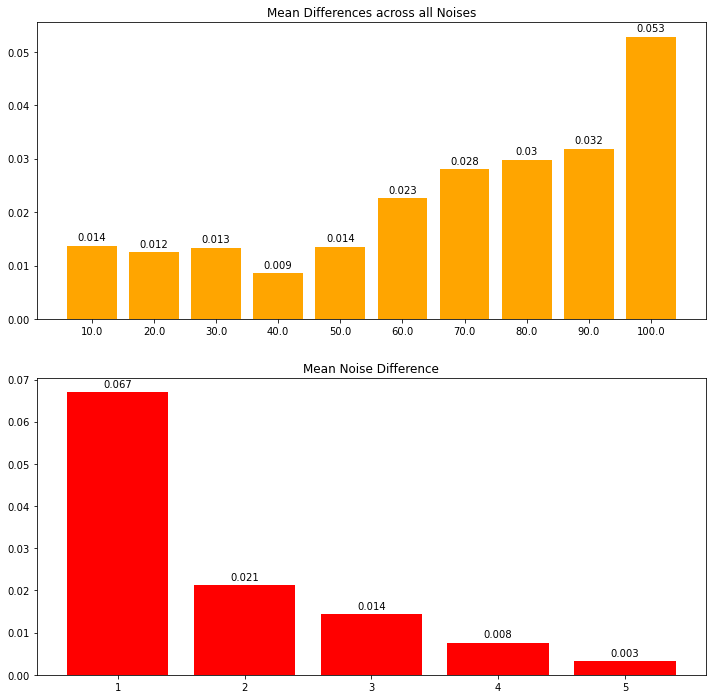

In [13]:
# PLOTS MEAN
for mean_noise_value_i in mean_noise_values_conf[:5]:
    print(mean_noise_value_i[1])
    plot_conf_best_noises(
        mad_and_std_per_noise_and_percentage[mean_noise_value_i[1]]["raw"]
    )

In [14]:
# TRAVERSE MEAN
# REDO MAD
mad_noise_values_conf = []
for mean_noise_value_i in mean_noise_values_conf[:5]:
    print(mean_noise_value_i[1])
    print(mad_and_std_per_noise_and_percentage[mean_noise_value_i[1]]["noise"][0])
    mad_noise_values_conf.append((mad_and_std_per_noise_and_percentage[mean_noise_value_i[1]]["noise"][0], mean_noise_value_i[1]))

0.0,0.0,1.0,0.0
0.0067796610169491575


In [15]:
mad_noise_values_conf.sort()
print(mad_noise_values_conf)

[(0.0067796610169491575, '0.0,0.0,1.0,0.0')]


0.0,0.0,1.0,0.0
0.0067796610169491575


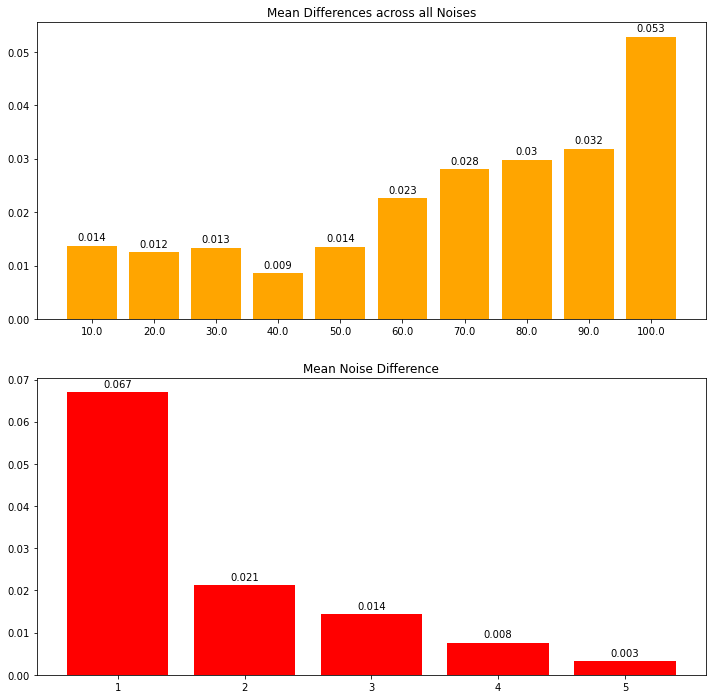

In [16]:
# PLOTS MAD
for mad_noise_value_i in mad_noise_values_conf[:5]:
    print(mad_noise_value_i[1])
    print(mad_and_std_per_noise_and_percentage[mad_noise_value_i[1]]["noise"][0])
    plot_conf_best_noises(
        mad_and_std_per_noise_and_percentage[mad_noise_value_i[1]]["raw"]
    )

# ANN

## Dataset

In [17]:
# Read database of phrase similarity
phrase_similarity_filename = "MTC-ANN-phrase-similarity.csv"
phrase_similarity_df = pd.read_csv(os.path.join(METADATA_PATH, phrase_similarity_filename), header=None)
phrase_similarity_df.head()

,0,1,2,3,4
0,NLB072587_01,0,a0,a0,b4
1,NLB072587_01,1,a0,a0,b4
2,NLB072587_01,2,b0,b0,c0
3,NLB072587_01,3,c0,c0,d0
4,NLB072587_02,0,a0,a1,b1


In [18]:
# Read table of tune family
tune_family_filename = "MTC-ANN-tune-family-labels.csv"
tune_family_df = pd.read_csv(os.path.join(METADATA_PATH, tune_family_filename), header=None)
tune_family_df.head()

,0,1
0,NLB072587_01,Daar_ging_een_heer_1
1,NLB072587_02,Daar_ging_een_heer_1
2,NLB072774_02,Daar_ging_een_heer_1
3,NLB073046_01,Daar_ging_een_heer_1
4,NLB073588_01,Daar_ging_een_heer_1


In [19]:
# Traverse musicxml files and tune family
song_id_x_family = {}
family_x_songs = {}
for root, directories, files in os.walk(MXML_PATH):
    for file in files:
        song_id = file.split(".")[0]
        if (song_id not in song_id_x_family):
            family_name = tune_family_df[tune_family_df[0] == song_id].iloc[0][1]
            song_id_x_family[song_id] = (file, family_name)
            if (family_name not in family_x_songs):
                family_x_songs[family_name] = []
            family_x_songs[family_name].append(song_id)

In [20]:
# Remove the incomplete anotated tunes from the dataframe
reduced_tune_family_df = tune_family_df[tune_family_df[0].isin(list(song_id_x_family.keys()))]
reduced_tune_family_df.head()

,0,1
0,NLB072587_01,Daar_ging_een_heer_1
1,NLB072587_02,Daar_ging_een_heer_1
2,NLB072774_02,Daar_ging_een_heer_1
3,NLB073046_01,Daar_ging_een_heer_1
4,NLB073588_01,Daar_ging_een_heer_1


## Functions

In [21]:
# Function to retrieve a list of midi pitch events and its timestamp
def getMelodyDeltaTimes(eventsintrack):
    
    # Initialize array
    DeltaTimes = []
    
    # Initialize cumulative sum
    cum_sum = 0
    
    # Initialize variable to track the time delta
    prev_deltatime = 0
    
    # Traverse the events
    for ev in eventsintrack:
        
        # If a note starts
        if (ev.isNoteOn()):
            
            # Get the pitch name and save it with the cumulative sum, midi pitch and name
            pitch_in_time = m21.pitch.Pitch(ev.pitch)
            DeltaTimes.append((cum_sum, prev_deltatime, pitch_in_time.midi, pitch_in_time.spanish))
            
            # Restart the delta time
            prev_deltatime = 0
        
        # Else if there is a delta time
        elif(str(ev.type) == "DeltaTime"):
            
            # We sum the time
            cum_sum += ev.time
            
            # We sum it to the current delta time
            prev_deltatime += ev.time
    
    # Return the array
    return DeltaTimes

In [22]:
# Function to retrieve a list of segments of midi pitch events and its timestamp from a stream
def getMelodyDeltaTimeSegmentsFromMelodyStream(melodystream):
    
    # Initialize array of arrays
    DeltaTimes = []
    
    # Initialize cumulative sum
    cum_sum = 0
    
    # Initialize variable to track the time delta
    prev_deltatime = 0
    
    # Current Segment
    curr_segment = []
    
    # Traverse the Notes in the stream
    for n in melodystream.parts[0].recurse().getElementsByClass('Note'):
        
        # We found a stop lyric
        if (n.lyric != None and n.lyric[0] == '!'):
            
            # We save the segment
            DeltaTimes.append(curr_segment)
            
            # We initialize the new segment
            curr_segment = []
            cum_sum = 0
            prev_deltatime = 0
        
        # We save the pitch
        pitch_in_time = m21.pitch.Pitch(n.pitch)
        curr_segment.append((cum_sum, prev_deltatime, pitch_in_time.midi, pitch_in_time.spanish, pitch_in_time))
        
        # We update the delta times
        cum_sum += m21.midi.translate.durationToMidiTicks(n.duration)
        prev_deltatime = m21.midi.translate.durationToMidiTicks(n.duration)
    
    # We save the last segment
    DeltaTimes.append(curr_segment)
    
    # We remove the initial empty list
    DeltaTimes.pop(0)
    
    # Return the array
    return DeltaTimes

In [23]:
def getSongKey(song):
    key = song.analyze("key")
    return key

In [24]:
def getSongKeyFromMelody_W_Times(melody_w_times_in_k):
    sc_test = m21.stream.Score()
    p0_test = m21.stream.Part()
    p0_test.id = 'part0'
    for pitch_i in melody_w_times_in_k:
        n_i = m21.note.Note(pitch_i[4])
        p0_test.append(n_i)
    sc_test.insert(0, p0_test)
    return getSongKey(sc_test)

In [25]:
def get_max_timestamp_dif(melody_w_times_A, melody_w_times_B):
    return max(
        melody_w_times_A[len(melody_w_times_A) - 1][0] - melody_w_times_A[0][0],
        melody_w_times_B[len(melody_w_times_B) - 1][0] - melody_w_times_B[0][0]
    )

In [26]:
def getDifSCLM(melody_w_times_A, melody_w_times_B, sclm):
    
    # If there is no sclm or it is just one return max possible value
    if (len(sclm) <= 1):
        return get_max_timestamp_dif(melody_w_times_A, melody_w_times_B)
    
    
    # Initialize the arrays
    T_A = np.zeros(shape=(len(sclm) - 1))
    T_B = np.zeros(shape=(len(sclm) - 1))
    T_C = np.zeros(shape=(len(sclm) - 1))
    Dif_ = np.zeros(shape=(len(sclm) - 1))
    
    for i in range(1, len(sclm)):
        T_A[i - 1] = melody_w_times_A[sclm[i][0]][0] - melody_w_times_A[sclm[i-1][0]][0]
        T_B[i - 1] = melody_w_times_B[sclm[i][1]][0] - melody_w_times_B[sclm[i-1][1]][0]
        T_C[i - 1] = np.abs(T_A[i - 1] - T_B[i - 1])
    
    T_C_mean = np.mean(T_C)
    
    for i in range(0, len(T_B)):
        T_B[i] += T_C_mean
        Dif_[i] = T_A[i] - T_B[i]
    
    return T_C_mean
    

In [27]:
def get_SCLM_v100(melody_w_times_A, melody_w_times_B):
    
    # We use a Dynamic Programming approach
    max_len = max(len(melody_w_times_A), len(melody_w_times_B)) + 1
    
    # memoization array
    memo = np.full(shape=(max_len,max_len), fill_value=-1)
    
    # Get the limits for each melody
    lim_A = len(melody_w_times_A)
    lim_B = len(melody_w_times_B)
    
    # Actual DP implementation
    for i in range(lim_A, -1, -1):
        for j in range(lim_B, -1, -1):
            
            # If we are at the limits the solution is 0
            if i == lim_A or  j == lim_B:
                memo[i][j] = 0
                continue
            
            # If there is a match a possible solution is the previous plus one
            curr_value = 0
            
            tot_delta_time = (float(melody_w_times_A[i][1]) + float(melody_w_times_B[j][1])) / float(DIV_CONST)
            tot_diff_time = np.abs(float(melody_w_times_A[i][1]) - float(melody_w_times_B[j][1]))
            
            
            if (melody_w_times_A[i][3] == melody_w_times_B[j][3]) and (tot_diff_time <= tot_delta_time):
                curr_value = memo[i + 1][j + 1] + 1
                
            # The actual solution is the maximum between the one if there is a match, or skip on the melody A or melody B
            curr_value = max(curr_value, max(memo[i + 1][j], memo[i][j + 1]))
            
            # Save the solution
            memo[i][j] = curr_value
    
    # With the memoization table we can retrieve the actual melody
    i = 0
    j = 0
    SCLM = []
    while i != lim_A and j != lim_B:
    
        if ((memo[i + 1][j + 1] + 1) == memo[i][j]):
            SCLM.append((i, j))
            i += 1
            j += 1
        elif (memo[i + 1][j] == memo[i][j]):
            i += 1
        elif (memo[i][j + 1] == memo[i][j]):
            j += 1
    
    return SCLM

In [28]:
def get_MTRC_v100_from_melody_w_times(melody_w_times_A, melody_w_times_B):
    
    # Assert at least one element for each melody
    if (len(melody_w_times_A) == 0 or len(melody_w_times_B) == 0):
        return 1
    
    # Initialize result variable
    result_value = 0
    
    # Get Keys
    key_A = getSongKeyFromMelody_W_Times(melody_w_times_A)
    key_B = getSongKeyFromMelody_W_Times(melody_w_times_B)
    
    # D1: Scale  
    scale_dif1 = 0
    if (key_A.name != key_B.name):
        scale_dif1 = W1
    result_value += scale_dif1
    
    # D2: Mode  
    mode_dif2 = 0
    if (key_A.mode != key_B.mode):
        mode_dif2 = W2
    result_value += mode_dif2
    
    # Get SCLM v100
    sclm = get_SCLM_v100(melody_w_times_A, melody_w_times_B)
    
    # Get max len
    max_len = max(len(melody_w_times_A), len(melody_w_times_B))
    
    # D3: SCLM Length
    sclmlen_dif3 = ((max_len - len(sclm)) / max_len) * W3
    result_value += sclmlen_dif3
    
    # Get the Diff on temporal spacing in the SCLM
    dif_sclm = getDifSCLM(melody_w_times_A, melody_w_times_B, sclm)
    
    # D4: dif in sclm
    max_timestamp_dif = get_max_timestamp_dif(melody_w_times_A, melody_w_times_B)
    sclmdif_dif4 = (dif_sclm / max_timestamp_dif) * W4
    result_value += sclmdif_dif4
    
    return result_value

In [29]:
def get_expert_score_from_tags(tag_i, tag_j):
    
    # If distinct letter no similarity
    if (tag_i[0] != tag_j[0]):
        return 1.0
    
    # If same letter and same number full similarity
    if (tag_i[1] == tag_j[1]):
        return 0.0
    
    # Otherwise "some" similarity
    return 0.5

In [30]:
def get_total_mean_dif_with_experts_by_song_ids(total_mean_differences_w_experts):
    total_scores_by_expert = [[], [], []]
    for song_id in total_mean_differences_w_experts:
        total_scores_by_expert[0].append(total_mean_differences_w_experts[song_id][0])
        total_scores_by_expert[1].append(total_mean_differences_w_experts[song_id][1])
        total_scores_by_expert[2].append(total_mean_differences_w_experts[song_id][2])
    total_mean_dif_score_1 = np.mean(total_scores_by_expert[0])
    total_mean_dif_score_2 = np.mean(total_scores_by_expert[1])
    total_mean_dif_score_3 = np.mean(total_scores_by_expert[2])
    return (total_mean_dif_score_1, total_mean_dif_score_2, total_mean_dif_score_3)

In [31]:
def get_threshold(val_x):
    
    if (0.0 <= val_x and val_x <= 0.33):
        return 0.0
    
    if (0.33 < val_x and val_x <= 0.66):
        return 0.5
    
    return 1.0

In [32]:
def plot_confs_annotators(confs, mean_scores):
    len_confs = len(confs)
    fig, axs = plt.subplots(len_confs, 3, figsize=(15, 6 * len_confs))
    graph_i = 0
    for conf_i in range(len_confs):
        for ann in range(1, 4):
            axs_to_plot = None
            if (len(confs) > 1):
                axs_to_plot = axs[conf_i][ann - 1]
            else:
                axs_to_plot = axs[ann - 1]
            
            rects = axs_to_plot.bar(["0.0", "0.5", "1.0"], mean_scores[confs[conf_i]][ann][:-1])
            autolabel(rects, axs_to_plot)
            axs_to_plot.set_title(label="Annotator #" + str(ann))
            
    fig.suptitle('Difference Plots')

In [33]:
def get_metric_range_to_100(val_x):
    return (val_x * 1.0) / (0.7)

In [34]:
%%time
# Define testing weights (Best in noisy evaluation 101)
TOT_N = 10
LEN_TUNES = len(reduced_tune_family_df[0])

# We traverse the noisy confs with best objective evaluations
scores_metric_and_experts = {}
conf_i = 1
for mad_noise_value_i in mean_noise_values_conf[:TOT_N]:
    print(mad_noise_value_i[1])
    
  
    scores_metric_and_experts[mad_noise_value_i[1]] = {}
    (W1, W2, W3, W4) = get_weights_from_encoded_conf(mad_noise_value_i[1])

    # traverse melodies
    cnt_tunes = 1
    for melody_id in reduced_tune_family_df[0]:
        print(melody_id)

        # We initialize the melody_id
        scores_metric_and_experts[mad_noise_value_i[1]][melody_id] = []

        # We get the stream from file
        melody_stream_i = m21.converter.parseFile(os.path.join(MXML_PATH, melody_id + ".musicxml"))

        # We get the melody delta segments
        melody_deltas_i = getMelodyDeltaTimeSegmentsFromMelodyStream(melody_stream_i)

        # We get the current tag by experts
        exp_tag_1 = phrase_similarity_df[phrase_similarity_df[0] == melody_id][2]
        exp_tag_2 = phrase_similarity_df[phrase_similarity_df[0] == melody_id][3]
        exp_tag_3 = phrase_similarity_df[phrase_similarity_df[0] == melody_id][4]

        # We calculate the distance between each pair of segments
        len_mdlts = len(melody_deltas_i)
        for i in range(len_mdlts):
            for j in range(len_mdlts):

                # We get the metric value for the current pair
                calculated_mtrc = get_MTRC_v100_from_melody_w_times(melody_deltas_i[i], melody_deltas_i[j])
                # calculated_mtrc = get_metric_range_to_100(calculated_mtrc)

                # We get the score by the experts on the current pair
                expert_score_1 = get_expert_score_from_tags(exp_tag_1.iloc[i], exp_tag_1.iloc[j])
                expert_score_2 = get_expert_score_from_tags(exp_tag_2.iloc[i], exp_tag_2.iloc[j])
                expert_score_3 = get_expert_score_from_tags(exp_tag_3.iloc[i], exp_tag_3.iloc[j])
                # print((expert_score_1, exp_tag_1.iloc[i], exp_tag_1.iloc[j]))

                # We save the scores
                scores_metric_and_experts[mad_noise_value_i[1]][melody_id].append((
                    calculated_mtrc,
                    expert_score_1,
                    expert_score_2,
                    expert_score_3
                ))

        # We print the progress
        print((W1, W2, W3, W4))
        print(f"CONF: {conf_i}/{len(mean_noise_values_conf[:TOT_N])} - MEL: {cnt_tunes}/{LEN_TUNES}")

        cnt_tunes += 1
    conf_i += 1

0.0,0.0,1.0,0.0
NLB072587_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 1/355
NLB072587_02
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 2/355
NLB072774_02
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 3/355
NLB073046_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 4/355
NLB073588_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 5/355
NLB073672_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 6/355
NLB073681_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 7/355
NLB073743_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 8/355
NLB073822_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 9/355
NLB074004_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 10/355
NLB074048_02
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 11/355
NLB074227_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 12/355
NLB075551_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 13/355
NLB076625_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 14/355
NLB076632_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 15/355
NLB144072_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 16/355
NLB070801_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 17/355
NLB0721

(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 142/355
NLB146699_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 143/355
NLB151180_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 144/355
NLB152778_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 145/355
NLB072355_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 146/355
NLB072355_02
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 147/355
NLB072355_12
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 148/355
NLB072356_02
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 149/355
NLB072357_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 150/355
NLB072358_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 151/355
NLB072359_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 152/355
NLB072360_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 153/355
NLB072457_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 154/355
NLB073775_02
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 155/355
NLB074260_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 156/355
NLB074260_02
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 157/355
NLB074334_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 158/355
NLB074336_

(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 281/355
NLB112233_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 282/355
NLB125427_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 283/355
NLB134480_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 284/355
NLB135273_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 285/355
NLB145856_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 286/355
NLB167193_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 287/355
NLB072624_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 288/355
NLB072968_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 289/355
NLB074007_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 290/355
NLB074038_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 291/355
NLB075079_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 292/355
NLB075307_03
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 293/355
NLB146741_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 294/355
NLB152784_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 295/355
NLB072103_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 296/355
NLB072283_01
(0.0, 0.0, 1.0, 0.0)
CONF: 1/1 - MEL: 297/355
NLB072284_

In [35]:
ts = time.time()
with open('./HEURISTIC_TEMPOMETRIC_1_{0}_ANN_RAW_v106_{1}.json'.format(DIV_CONST, str(ts)), 'w') as outfile:
    json.dump(scores_metric_and_experts, outfile)

In [37]:
scores_metric_and_experts_LOADED = []
with open('./HEURISTIC_TEMPOMETRIC_1_{0}_ANN_RAW_v106_1606936455.4964356.json'.format(DIV_CONST)) as json_file:
    scores_metric_and_experts_LOADED = json.load(json_file)

In [38]:
%%time
# Initialize lists for annotators ann1, ann2, ann3
score_annotators_diff_no_thd = {}

cnt = 0
for conf in scores_metric_and_experts_LOADED:
    score_annotators_diff_no_thd[conf] = [[],[],[],[]]

    # Initialize also three lists for each anotator
    for i in range(len(score_annotators_diff_no_thd[conf])):
        score_annotators_diff_no_thd[conf][i] = {
            0.0:[],
            0.5:[],
            1.0:[]
        }
    
    # Traverse the scores
    for song_id in scores_metric_and_experts_LOADED[conf]:
        for score_results in scores_metric_and_experts_LOADED[conf][song_id]:
            
            # Score by the metric
            mtrc_score = score_results[0]
            
            # Score by annotator
            seen_scores = {}
            for ann in range(1,4):
                if (score_results[ann] not in seen_scores):
                    seen_scores[score_results[ann]] = 0
                seen_scores[score_results[ann]] += 1
                score_annotators_diff_no_thd[conf][ann][score_results[ann]].append(
                    np.abs(mtrc_score - score_results[ann])
                )
                
            if (len(seen_scores) > 2):
                continue
            # Score by majority of the annotators (if exists)
            majority_score = max(seen_scores, key=seen_scores.get)
            score_annotators_diff_no_thd[conf][0][majority_score].append(
                np.abs(mtrc_score - majority_score)
            )

CPU times: user 70 ms, sys: 0 ns, total: 70 ms
Wall time: 69.7 ms


In [39]:
%%time
means_per_conf_no_thd = {}
for conf in score_annotators_diff_no_thd:
    mean_per_ann = []
    for ann in range(4):
        mean_per_ann.append([])
        for key_val in score_annotators_diff_no_thd[conf][ann]:
            mean_per_ann[ann].append(
                np.mean(score_annotators_diff_no_thd[conf][ann][key_val])
            )
        # Add mean of means
        mean_per_ann[ann].append(np.mean(mean_per_ann[ann]))
    means_per_conf_no_thd[conf] = mean_per_ann
means_per_conf_no_thd

CPU times: user 131 µs, sys: 3.99 ms, total: 4.13 ms
Wall time: 4 ms


In [40]:
ann_confs = ['0.0,0.0,1.0,0.0',]

CPU times: user 41.3 ms, sys: 1 µs, total: 41.3 ms
Wall time: 40.9 ms


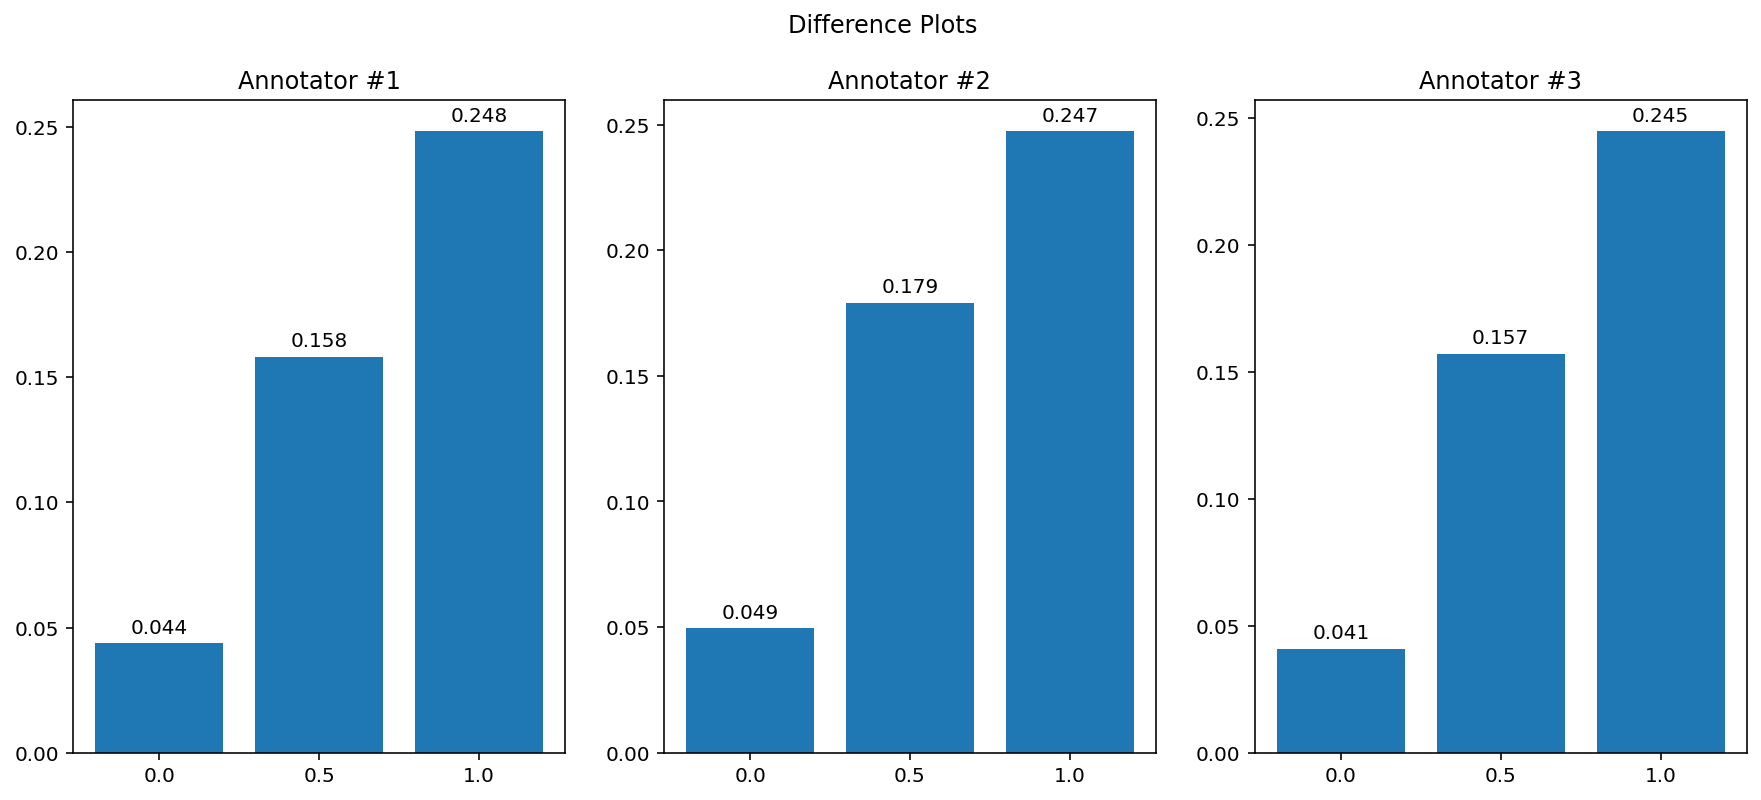

In [41]:
%%time
for ann_conf in ann_confs:
    plot_confs_annotators([ann_conf], means_per_conf_no_thd)

# END ANN

In [42]:
for conf_arr_i in ['0.0,0.0,1.0,0.0']:
    str_per_conf = " & ".join(conf_arr_i.split(",")) + " & "
    means_per_ann = []
    for ann in range(1, 4):
        means_per_ann.append(round(np.mean(means_per_conf_no_thd[conf_arr_i][ann][:-1]), 4))
        str_per_conf = str_per_conf + str(means_per_ann[-1]) + " & "
    str_per_conf = str_per_conf + str(round(np.mean(means_per_ann), 4)) + " \\\\"
    print(str_per_conf)
    print("\hline")

0.0 & 0.0 & 1.0 & 0.0 & 0.1501 & 0.1587 & 0.1475 & 0.1521 \\
\hline


In [44]:
print("1_2, 0.1661 & 0.1745 & 0.1661 & 0.1689")
print("1_4, 0.151 & 0.16 & 0.1489 & 0.1533")
print("1_64,0.1501 & 0.1587 & 0.1475 & 0.1521")

1_2, 0.1661 & 0.1745 & 0.1661 & 0.1689
1_4, 0.151 & 0.16 & 0.1489 & 0.1533
1_64,0.1501 & 0.1587 & 0.1475 & 0.1521
